# GIK Character Prediction Model

Train an LSTM model to predict keyboard characters from IMU sensor data.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_and_export, load_preprocessed_dataset, export_dataset_to_csv
from src.pre_processing.alignment import INDEX_TO_CHAR, CHAR_TO_INDEX
from ml.models.basic_nn import create_model_from_dataset, GIKTrainer, decode_predictions

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0 | Device: mps


## Configuration

In [2]:
# Data paths
DATA_DIR = "data_hazel_1"
KEYBOARD_FILE = "Keyboard_1.csv"
LEFT_FILE = "Left_1.csv"      # Set to None if not available
RIGHT_FILE = None              # Set to None if not available
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training config - OPTIMIZED (best: transformer with 24.5% test acc)
CONFIG = {
    'max_seq_length': 100,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.3,
    'batch_size': 32,
    'learning_rate': 5e-4,
    'epochs': 50,
    'early_stopping': 10,
    # Model: 'transformer' (best) | 'attention_lstm' | 'lstm' | 'gru' | 'rnn' | 'cnn'
    'model_type': 'transformer',
}

print(f"Data dir: {DATA_DIR}")
print(f"Keyboard: {KEYBOARD_FILE}")
print(f"Left IMU: {LEFT_FILE}")
print(f"Right IMU: {RIGHT_FILE}")
print(f"Model: {CONFIG['model_type']}")print(f"Seq length: {CONFIG['max_seq_length']}")

Data dir: data_hazel_1
Keyboard: Keyboard_1.csv
Left IMU: Left_1.csv
Right IMU: None
Model: lstm


## Preprocess Data

In [4]:
metadata = preprocess_and_export(
    data_dir=DATA_DIR,
    keyboard_file=KEYBOARD_FILE,
    left_file=LEFT_FILE,
    right_file=RIGHT_FILE,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True
)
print(f"\nSamples: {metadata['num_samples']} | Input dim: {metadata['input_dim']}")

Loading data from data_hazel_1...
Aligning IMU data with keyboard events...


/Users/souparna/perceptron-gik/src/imu/v1/mathlib.py:7: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)
/Users/souparna/perceptron-gik/src/imu/v1/main.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  Ra = [(acc_noise/np.linalg.norm(at))**2 + (1 - grm/np.linalg.norm(at))**2]*3


Skipped characters not in vocabulary: {'shift': 2, '*': 2}
Processing 2111 samples...
Saved preprocessed dataset to data_hazel_1/processed_dataset.pt
Saved metadata to data_hazel_1/processed_dataset_metadata.json
  - Samples: 2111
  - Input dim: 99
  - Hands: 1

Samples: 2111 | Input dim: 99


In [5]:
# Export to CSV for inspection (optional)
export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

Saved summary to data_hazel_1/dataset_summary.csv
Saved features to data_hazel_1/dataset_features.csv

Dataset Info:
  Total samples: 2111
  Exported samples: 2111
  Input dim: 99
  Max seq length: 10
  Num classes: 40

Class Distribution:
  SPACE: 384
  e: 225
  o: 157
  t: 132
  n: 116
  a: 116
  l: 110
  r: 95
  i: 88
  s: 82
  h: 81
  w: 57
  d: 53
  m: 51
  g: 46


'data_hazel_1/dataset_summary.csv'

## Load Dataset & Create Model

In [6]:
dataset = load_preprocessed_dataset(PROCESSED_DATA_PATH)
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model
model = create_model_from_dataset(
    dataset,
    model_type=CONFIG['model_type'],
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout'],
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 2111 samples | Input dim: 99

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=99, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (inner_model): LSTMModel(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=40, bias=True)
  )
)
Parameters: 716,264
Parameters: 716,264


## Train Model

In [7]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on mps
Train: 1688, Val: 211, Test: 212 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/200 | Train Loss: 3.5732 | Train Acc: 0.0415 | Val Loss: 3.5525 | Val Acc: 0.0379
  -> Saved best model (val_loss: 3.5525)
Epoch   2/200 | Train Loss: 3.4236 | Train Acc: 0.0367 | Val Loss: 3.5900 | Val Acc: 0.0521
Epoch   3/200 | Train Loss: 3.3435 | Train Acc: 0.0616 | Val Loss: 3.4591 | Val Acc: 0.1706
  -> Saved best model (val_loss: 3.4591)
Epoch   4/200 | Train Loss: 3.2066 | Train Acc: 0.0835 | Val Loss: 3.3819 | Val Acc: 0.1422
  -> Saved best model (val_loss: 3.3819)
Epoch   5/200 | Train Loss: 3.0327 | Train Acc: 0.1220 | Val Loss: 3.2588 | Val Acc: 0.1517
  -> Saved best model (val_loss: 3.2588)
Epoch   6/200 | Train Loss: 2.8478 | Train Acc: 0.1297 | Val Loss: 3.3540 | Val Acc: 0.1754
Epoch   7/200 | Train Loss: 2.7390 | Train Acc: 0.1629 | Val Loss: 3.2904 | Val Acc: 0.1801
Epoch   8/200 | Train Loss: 2.5765 | Train Acc: 0.1890 

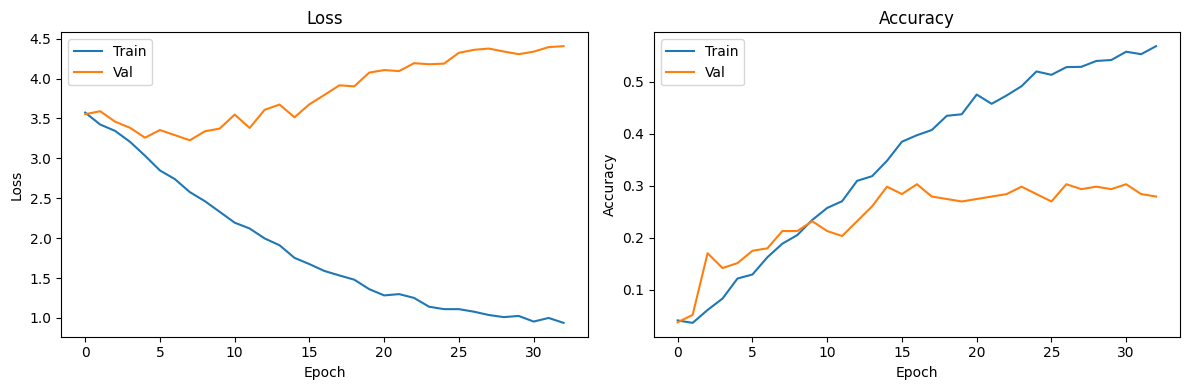

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

## Evaluate Model

In [13]:
# Evaluate on validation set
val_loss, val_acc = trainer.validate()
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2%}")
print()

# Evaluate on test set
test_loss, test_acc = trainer.evaluate_test()
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2%}")

Validation Loss: 4.4051 | Validation Accuracy: 27.96%

Test Loss: 3.5358 | Test Accuracy: 23.11%


In [14]:
# Helper function to display predictions
def show_predictions(data_subset, subset_name, max_samples=50):
    """Show predictions for a dataset subset."""
    model.eval()
    correct = 0
    results = []
    
    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            
            true_char = INDEX_TO_CHAR.get(y_true.argmax().item(), '?')
            pred_char = INDEX_TO_CHAR.get(y_pred.argmax().item(), '?')
            
            is_correct = true_char == pred_char
            if is_correct:
                correct += 1
            
            results.append((true_char, pred_char, is_correct))
    
    # Print header
    print(f"=== {subset_name} Predictions ({correct}/{len(results)} correct = {correct/len(results):.2%}) ===")
    print()
    
    # Show samples (up to max_samples)
    n_show = min(max_samples, len(results))
    for i, (true_char, pred_char, is_correct) in enumerate(results[:n_show]):
        # Display special chars nicely
        true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
        pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
        match = '✓' if is_correct else '✗'
        print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")
    
    if len(results) > n_show:
        print(f"... and {len(results) - n_show} more samples")
    print()

In [15]:
# Show validation predictions
show_predictions(trainer.val_dataset, 'Validation')

=== Validation Predictions (63/211 correct = 29.86%) ===

✗ True: SPACE    | Pred: n       
✓ True: s        | Pred: s       
✗ True: o        | Pred: h       
✗ True: SPACE    | Pred: r       
✓ True: h        | Pred: h       
✓ True: e        | Pred: e       
✗ True: s        | Pred: a       
✓ True: e        | Pred: e       
✗ True: SPACE    | Pred: n       
✗ True: h        | Pred: i       
✗ True: i        | Pred: e       
✗ True: g        | Pred: n       
✓ True: h        | Pred: h       
✗ True: SPACE    | Pred: o       
✗ True: s        | Pred: w       
✓ True: h        | Pred: h       
✗ True: o        | Pred: i       
✓ True: u        | Pred: u       
✗ True: l        | Pred: b       
✓ True: d        | Pred: d       
✗ True: SPACE    | Pred: o       
✗ True: u        | Pred: i       
✓ True: s        | Pred: s       
✓ True: e        | Pred: e       
✗ True: SPACE    | Pred: n       
✗ True: l        | Pred: i       
✗ True: o        | Pred: l       
✗ True: n        | Pred:

In [16]:
# Show test predictions
show_predictions(trainer.test_dataset, 'Test')

=== Test Predictions (50/212 correct = 23.58%) ===

✗ True: o        | Pred: i       
✗ True: w        | Pred: u       
✗ True: SPACE    | Pred: h       
✗ True: l        | Pred: o       
✓ True: a        | Pred: a       
✓ True: s        | Pred: s       
✓ True: t        | Pred: t       
✓ True: SPACE    | Pred: SPACE   
✗ True: s        | Pred: t       
✗ True: r        | Pred: t       
✗ True: r        | Pred: g       
✗ True: m        | Pred: d       
✗ True: SPACE    | Pred: i       
✗ True: a        | Pred: w       
✗ True: l        | Pred: t       
✗ True: s        | Pred: i       
✗ True: o        | Pred: h       
✓ True: SPACE    | Pred: SPACE   
✗ True: g        | Pred: t       
✗ True: r        | Pred: h       
✗ True: o        | Pred: k       
✗ True: u        | Pred: i       
✗ True: p        | Pred: i       
✓ True: SPACE    | Pred: SPACE   
✗ True: p        | Pred: g       
✗ True: l        | Pred: i       
✗ True: a        | Pred: l       
✗ True: y        | Pred: s    

## Save Model

In [10]:
MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'input_dim': dataset.input_dim,
    'metadata': metadata
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to data_hazel_1/gik_model.pt
